### Spectral analysis

In [1]:
%matplotlib inline

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker
from gammapy.makers.utils import make_theta_squared_table
from gammapy.maps import Map, MapAxis, WcsGeom, RegionGeom, WcsNDMap

from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_theta_squared_table
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.data import EventList
from gammapy.datasets import Datasets, MapDataset
from gammapy.irf import EDispKernelMap, PSFMap
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
    ExpCutoffPowerLawSpectralModel,
    SuperExpCutoffPowerLaw4FGLDR3SpectralModel,
    LogParabolaSpectralModel,
    LogParabolaNormSpectralModel,
    create_crab_spectral_model
)
import numpy as np
from regions import CircleSkyRegion
from pathlib import Path
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import (
    FluxPointsEstimator,
    FluxPoints,
    FluxProfileEstimator
    )
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.utils.regions import (
    make_concentric_annulus_sky_regions,
    make_orthogonal_rectangle_sky_regions,
)


#### Model for RGB J0521+212

In [2]:
spatial_model_rgb = PointSpatialModel(
    lon_0='183.6042 deg',
    lat_0='-8.7083 deg',
    frame='galactic')
spectral_model_rgb = LogParabolaSpectralModel(
    alpha=1.753,
    amplitude=4.06e-11 * u.Unit('cm-2 s-1 GeV-1'),
    reference=18.441 * u.Unit('GeV'),
    beta=0.248,
)

source_rgb = SkyModel(
    spectral_model=spectral_model_rgb,
    spatial_model=spatial_model_rgb,
    datasets_names=['fermi-dataset'],
    name='RGB J0512+212'
)


#### Model for the Crab Pulsar

In [3]:
spatial_model_pulsar = PointSpatialModel(
    lon_0 = '184.56 deg',
    lat_0 = '-5.79 deg',
    frame='galactic'
)
spectral_model_pulsar= SuperExpCutoffPowerLaw4FGLDR3SpectralModel(
    index_1= 2.3200104,
    index_2= 0.6103486,
    reference=1592.4111 * u.Unit('MeV'),
    amplitude=7.490237e-11 * u.Unit('cm-2 s-1 MeV-1'),
    expfactor=0.23666985 
)
source_pulsar = SkyModel(
    spectral_model=spectral_model_pulsar,
    spatial_model=spatial_model_pulsar,
    datasets_names=['fermi-dataset'],
    name='crab pulsar'
)


#### *Fermi* data and models

In [4]:
events = EventList.read(
    "$thesis_path/fermi/gtmktime_crab_new.fits"
    )
print(events)
energy = events.energy


EventList
---------

  Instrument       : LAT
  Telescope        : GLAST
  Obs. ID          : 

  Number of events : 128243
  Event rate       : 0.000 1 / s

  Time start       : 54682.65603222222
  Time stop        : 60047.32424981481

  Min. energy      : 1.00e+03 MeV
  Max. energy      : 5.15e+06 MeV
  Median energy    : 1.64e+03 MeV




MapAxis

	name       : energy    
	unit       : 'GeV'     
	nbins      : 14        
	node type  : edges     
	edges min  : 1.0e+00 GeV
	edges max  : 9.0e+02 GeV
	interp     : log       



<WCSAxesSubplot: >

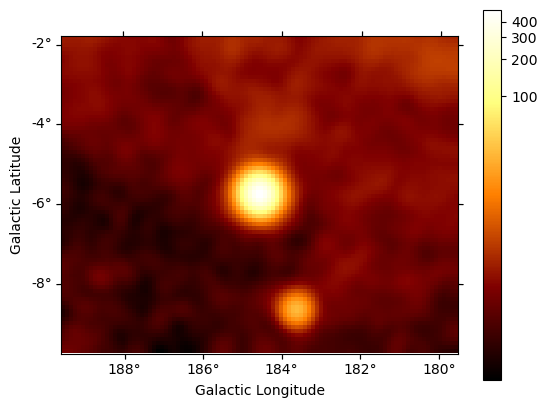

In [5]:
gc_pos = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
energy_axis = MapAxis.from_energy_edges(
    np.logspace(0,np.log10(900),15,base=10),
    unit="GeV",
    interp="log"
)
counts = Map.create(
    skydir=gc_pos,
    npix=(100, 80),
    proj="TAN",
    frame="galactic",
    binsz=0.1,
    axes=[energy_axis],
    dtype=float,
)
counts.fill_events(events)

print(counts.geom.axes[0])

plt.figure()
counts.sum_over_axes().smooth(2).plot(stretch="log", add_cbar=True)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 60047.323442 from DATE-END'. [astropy.wcs.wcs]


WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (300, 300, 33)
	ndim       : 3
	frame      : fk5
	projection : AIT
	center     : 83.6 deg, 22.0 deg
	width      : 30.0 deg x 30.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

MapAxis

	name       : energy_true
	unit       : 'MeV'     
	nbins      : 33        
	node type  : center    
	center min : 1.0e+03 MeV
	center max : 1.0e+07 MeV
	interp     : log       



<WCSAxesSubplot: >

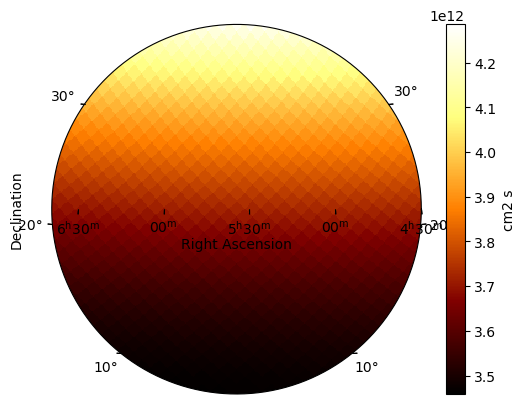

In [6]:
exposure_hpx = Map.read(
    "$thesis_path/fermi/expcube_corrected_PSF3.fits"
    )
print(exposure_hpx.geom)
print(exposure_hpx.geom.axes[0])

plt.figure()
exposure_hpx.sum_over_axes().plot(add_cbar=True)
# exposure_hpx.plot_interactive(add_cbar=True)


In [7]:
axis = MapAxis.from_energy_bounds(
    "1 GeV",
    "900 GeV",
    nbin=15,
    per_decade=True,
    name="energy_true",
)
geom = WcsGeom(wcs=counts.geom.wcs, npix=counts.geom.npix, axes=[axis])

exposure = exposure_hpx.interp_to_geom(geom)

print(exposure.geom)
print(exposure.geom.axes[0])


WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (100, 80, 45)
	ndim       : 3
	frame      : galactic
	projection : TAN
	center     : 184.6 deg, -5.8 deg
	width      : 10.0 deg x 8.0 deg
	wcs ref    : 184.6 deg, -5.8 deg

MapAxis

	name       : energy_true
	unit       : 'GeV'     
	nbins      : 45        
	node type  : edges     
	edges min  : 1.0e+00 GeV
	edges max  : 9.0e+02 GeV
	interp     : log       



WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (2880, 1441, 28)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : >f4



<WCSAxesSubplot: >

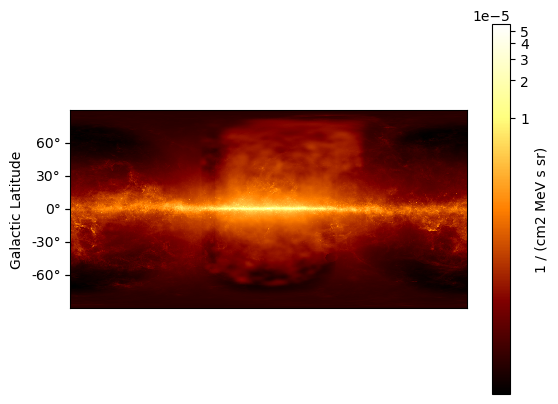

In [8]:
template_diffuse = TemplateSpatialModel.read(
    filename="$thesis_path/fermi/gll_iem_v07.fits",
    normalize=False
)
print(template_diffuse.map)

fermi_diffuse_iem = SkyModel(
    spectral_model=LogParabolaNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
    datasets_names=['fermi-dataset'] 
)

plt.figure()
template_diffuse.map.slice_by_idx({"energy_true": 0}).plot(
    add_cbar=True,
    stretch="log"
)


Text(0, 0.5, 'Flux (cm-2 s-1 MeV-1 sr-1)')

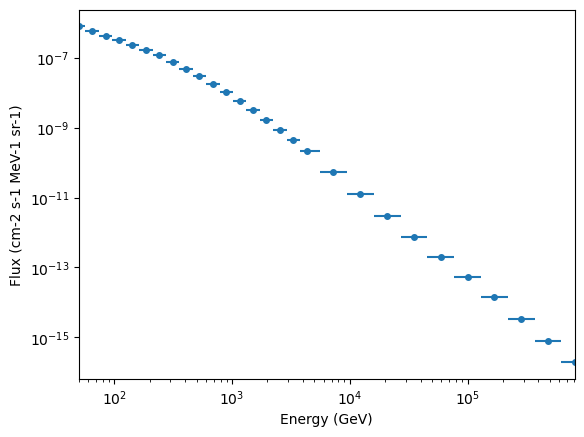

In [9]:
dnde = template_diffuse.map.to_region_nd_map(region=gc_pos)
plt.figure()
dnde.plot()
plt.xlabel("Energy (GeV)")
plt.ylabel("Flux (cm-2 s-1 MeV-1 sr-1)")


In [10]:
filename = "$thesis_path/fermi/iso_P8R3_SOURCE_V3_v1.txt"

fermi_diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename=filename, interp_kwargs={"fill_value": None} 
)


In [11]:
psf = PSFMap.read("$thesis_path/fermi/psf_crab_new.fits", format="gtpsf")
print(psf)


RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (1, 1, 300, 300)
	ndim  : 4
	unit  : 1 / sr
	dtype : >f8



<AxesSubplot: xlabel='True Energy [MeV]', ylabel='Containment radius (deg)'>

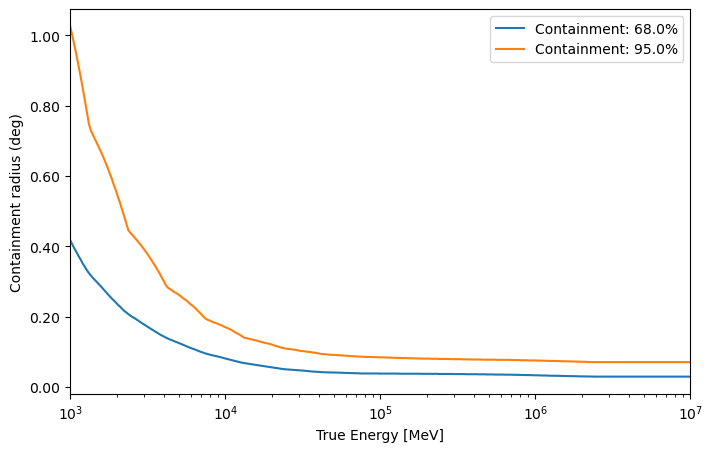

In [12]:
plt.figure(figsize=(8, 5))
psf.plot_containment_radius_vs_energy()


/home/melanie_federer/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/melanie_federer/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


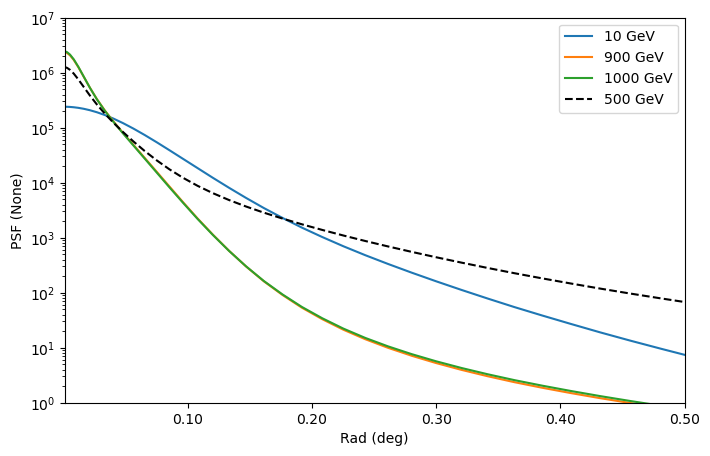

In [13]:
plt.figure(figsize=(8, 5))

energy = [10, 900, 1000] * u.GeV
psf.plot_psf_vs_rad(energy_true=energy)

spectrum = PowerLawSpectralModel(index=1)#2.3
psf_mean = psf.to_image(spectrum=spectrum)
psf_mean.plot_psf_vs_rad(c="k", ls="--", energy_true=[500] * u.GeV)

plt.xlim(1e-3, 0.5)
plt.ylim(1e0, 1e7)
plt.legend()


<WCSAxesSubplot: >

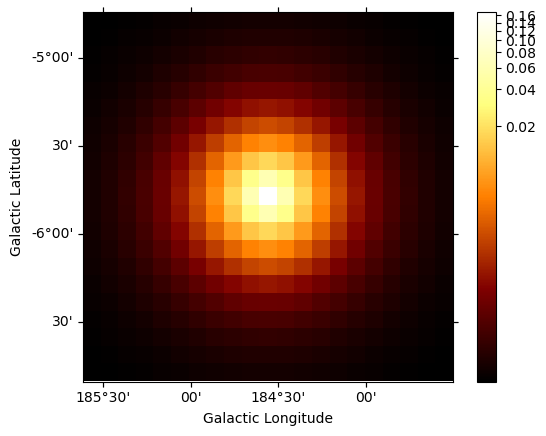

In [14]:
psf_kernel = psf.get_psf_kernel(
    position=geom.center_skydir, geom=geom, max_radius="1 deg"
)
plt.figure()
psf_kernel.to_image().psf_kernel_map.plot(stretch="log", add_cbar=True)


<AxesSubplot: xlabel='True Energy [GeV]', ylabel='Energy [GeV]'>

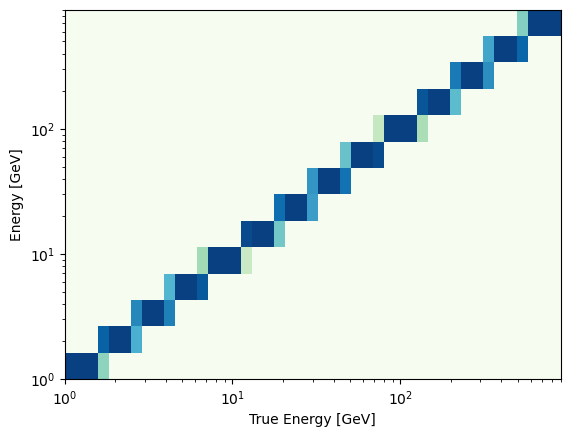

In [15]:
e_true = exposure.geom.axes["energy_true"]
edisp = EDispKernelMap.from_diagonal_response(
    energy_axis_true=e_true, energy_axis=energy_axis
)

plt.figure()
edisp.get_edisp_kernel().plot_matrix()


In [16]:
spatial_model = PointSpatialModel(
    lon_0='184.56 deg',
    lat_0='-5.79 deg',
    frame='galactic'
)
print(spatial_model)
spectral_model = LogParabolaSpectralModel(
    alpha=2.47,
    amplitude=3.23e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    beta=0.24,
)

source = SkyModel(
    spectral_model=spectral_model,
    spatial_model=spatial_model,
    name="source-crab",
)

models = Models([source, fermi_diffuse_iem, source_rgb, source_pulsar])
# models = Models([source])
# models = Models([source, fermi_diffuse_iem])
# models = Models([source, fermi_diffuse_iem, source_rgb])

dataset = MapDataset(
    models=models,
    counts=counts,
    exposure=exposure,
    psf=psf,
    edisp=edisp,
    name="fermi-dataset",
)


PointSpatialModel

  type   name    value    unit   error   ...    max    frozen is_norm link
------- ----- ----------- ---- --------- ... --------- ------ ------- ----
spatial lon_0  1.8456e+02  deg 0.000e+00 ...       nan  False   False     
spatial lat_0 -5.7900e+00  deg 0.000e+00 ... 9.000e+01  False   False     


In [17]:
fermi_diffuse_iso.datasets_names = dataset.name
models.append(fermi_diffuse_iso)

dataset.models = models

dataset.models['crab pulsar'].spectral_model.expfactor.frozen=True
dataset.models['crab pulsar'].spectral_model.index_1.frozen=True
dataset.models['crab pulsar'].spectral_model.index_2.frozen=True

print(dataset)


MapDataset
----------

  Name                            : fermi-dataset 

  Total counts                    : 47756 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 21057.57
  Predicted background counts     : nan
  Predicted excess counts         : 21057.57

  Exposure min                    : 1.11e+11 cm2 s
  Exposure max                    : 1.39e+11 cm2 s

  Number of total bins            : 112000 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -10463.92

  Number of models                : 5 
  Number of parameters            : 28
  Number of free parameters       : 17

  Component 0: SkyModel
  
    Name                      : source-crab
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      amplitu

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 3367
	total stat : -101342.01

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Models

Component 0: SkyModel

  Name                      : source-crab
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   4.84e-11   +/- 3.9e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.346   +/-    0.06             
    beta                          :      0.072   +/-    0.01             
    lon_0                         :    184.552   +/-    0.00 deg         
    lat_0                         :     -5.775   +/-    0.00 deg         

Compo

<WCSAxesSubplot: >

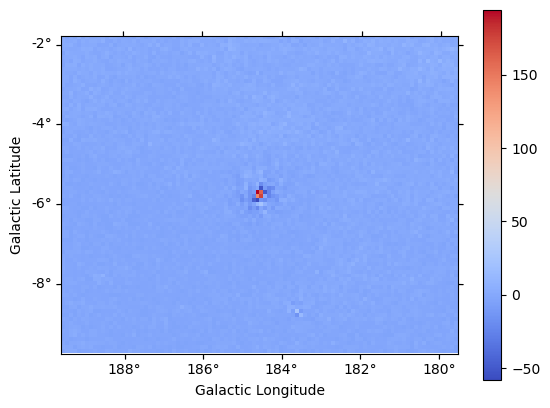

In [18]:
fit = Fit()
result = fit.run(datasets=[dataset])

print(result)

print(models)

residual = counts - dataset.npred()
resid = (counts - dataset.npred())/dataset.npred()

plt.figure()

residual.sum_over_axes().smooth("0.02 deg").plot(
    cmap="coolwarm", add_cbar=True, stretch='linear'
)
# resid.smooth("0.02 deg").plot_interactive(
#     cmap="coolwarm", add_cbar=True, vmin=-1, vmax=1
# )
# residual.smooth("0.02 deg").plot_interactive(
#     cmap="coolwarm", add_cbar=True
# )


In [19]:
Datasets([dataset]).write(
    filename="fermi_dataset.yaml",
    filename_models="fermi_models.yaml",
    overwrite=True
)
datasets_read = Datasets.read(
    filename="fermi_dataset.yaml",
    filename_models="fermi_models.yaml"
)
print(datasets_read)


Template file already exits, and overwrite is False
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi-dataset
  Instrument : 
  Models     : ['source-crab', 'diffuse-iem', 'RGB J0512+212', 'crab pulsar', 'fermi-diffuse-iso']




In [20]:
path = Path("$thesis_path")
filename = path / "fermi_dataset.yaml"

datasets = Datasets.read(filename=filename)

models = Models.read(path / "fermi_models.yaml")


Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


#### H.E.S.S. data

In [21]:
datastore = DataStore.from_dir("$thesis_path/Crab_Data/Crab_FITS_HAP_ImPACT")
obs_ids = np.genfromtxt(
    "/home/melanie_federer/python/gammapy/bachelor_thesis/Crab_Data/runlist_Crab.txt",
    dtype=int
)
observations = datastore.get_observations(obs_ids)


In [22]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)


In [23]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit='TeV', name='energy'
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit='TeV', name='energy_true'
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=['counts','exposure','edisp']
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)


In [24]:
datasets_hess = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    datasets_hess.append(dataset_on_off)

print(datasets_hess)


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 18922
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23309
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23310
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : HESS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : HESS
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 23544
  Instrument : HESS
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 23545
  Instrument : HESS
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : 23546
  Instrument : HESS
  Models     : 

Dataset 8: 

  Type       : SpectrumDatasetOnOff
  Name       : 23547
  Instrument : HESS
  Models     : 

Dataset 9: 

  Typ

Text(0, 0.5, 'Sqrt(TS)')

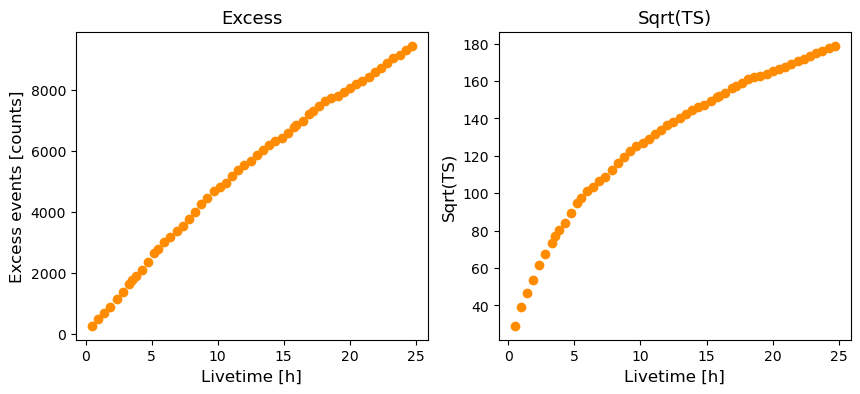

In [25]:
info_table = datasets_hess.info_table(cumulative=True)

fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10,4), ncols=2, nrows=1)
ax_excess.plot(
    info_table['livetime'].to('h'),
    info_table['excess'],
    marker='o',
    ls='none',
    color='darkorange' 
)

ax_excess.set_title('Excess',size=13)
ax_excess.set_xlabel('Livetime [h]',size=12)
ax_excess.set_ylabel('Excess events [counts]',size=12)

ax_sqrt_ts.plot(
    info_table['livetime'].to('h'),
    info_table['sqrt_ts'],
    marker='o',
    ls='none',
    color='darkorange'   
)

ax_sqrt_ts.set_title('Sqrt(TS)',size=13)
ax_sqrt_ts.set_xlabel('Livetime [h]',size=12)
ax_sqrt_ts.set_ylabel('Sqrt(TS)',size=12)


In [26]:
path = Path('spectrum_analysis_hess')
path.mkdir(exist_ok=True)

for dataset in datasets_hess:
    dataset.write(filename=path / f'obs_{dataset.name}.fits.gz', overwrite=True)
    

In [27]:
datasets_hess = Datasets()

for obs_id in obs_ids:
    filename = path / f'obs_{obs_id}.fits.gz'
    datasets_hess.append(SpectrumDatasetOnOff.read(filename))

dataset_hess = datasets_hess.stack_reduce(name="HESS")
datasets.append(dataset_hess)

print(datasets)


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi-dataset
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 




#### Serialization

In [28]:
path = Path("crab-FermiHessDatasets")
path.mkdir(exist_ok=True)

filename = path / "crab_1GeV_100TeV_datasets.yaml"
datasets.write(filename, overwrite=True)
datasets = Datasets.read(filename)
datasets.models = models

print(datasets)


HDU 'BACKGROUND' not found
HDU 'MASK_SAFE' not found
HDU 'MASK_FIT' not found


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi-dataset
  Instrument : 
  Models     : ['source-crab', 'diffuse-iem', 'RGB J0512+212', 'crab pulsar', 'fermi-diffuse-iso']

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : ['source-crab']




#### Joint Fit

In [29]:
fit_joint = Fit()
results_joint = fit_joint.run(datasets=datasets)
print(results_joint)


HDU 'MASK_SAFE' not found
HDU 'MASK_FIT' not found
HDU 'BACKGROUND' not found


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 417
	total stat : -101312.51

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [30]:
print(datasets[0])

MapDataset
----------

  Name                            : fermi-dataset 

  Total counts                    : 47756 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 47768.56
  Predicted background counts     : nan
  Predicted excess counts         : 47768.56

  Exposure min                    : 1.11e+11 cm2 s
  Exposure max                    : 1.39e+11 cm2 s

  Number of total bins            : 112000 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -101346.73

  Number of models                : 5 
  Number of parameters            : 28
  Number of free parameters       : 17

  Component 0: SkyModel
  
    Name                      : source-crab
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      amplit

In [31]:
print(datasets[1])

SpectrumDatasetOnOff
--------------------

  Name                            : HESS 

  Total counts                    : 9885 
  Total background counts         : 437.43
  Total excess counts             : 9447.57

  Predicted counts                : 9868.71
  Predicted background counts     : 437.71
  Predicted excess counts         : 9431.00

  Exposure min                    : 9.36e+02 m2 s
  Exposure max                    : 4.42e+10 m2 s

  Number of total bins            : 27 
  Number of fit bins              : 21 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 34.22

  Number of models                : 1 
  Number of parameters            : 6
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : source-crab
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
     

In [32]:
crab_spec = datasets[1].models["source-crab"].spectral_model
pulsar_spec = datasets[0].models["crab pulsar"].spectral_model
print(crab_spec)
print('\n', pulsar_spec)


LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 4.0628e-11 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.5007e+00                ... nan  False   False     
spectral      beta 9.8749e-02                ... nan  False   False     

 SuperExpCutoffPowerLaw4FGLDR3SpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 7.3083e-11 cm-2 MeV-1 s-1 ... nan  False    True     
spectral reference 1.5924e+03            MeV ... nan   True   False     
spectral expfactor 2.3667e-01                ... nan   True   False     
spectral   index_1 2.3200e+00                ... nan   True   False     
spectral   index_2 6.1035e-01                ... nan

In [33]:
energy_edges = MapAxis.from_energy_bounds("1 GeV", "900 GeV", nbin=7).edges

flux_points_fermi = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="source-crab",
    norm_min=1,
    norm_max=1
).run([datasets["fermi-dataset"]])

energy_edges = MapAxis.from_bounds(
    0.2, 40, nbin=7, interp="log", unit="TeV"
    ).edges

flux_points_hess = FluxPointsEstimator(
    energy_edges=energy_edges, source="source-crab", selection_optional=["ul"]
).run([datasets["HESS"]])


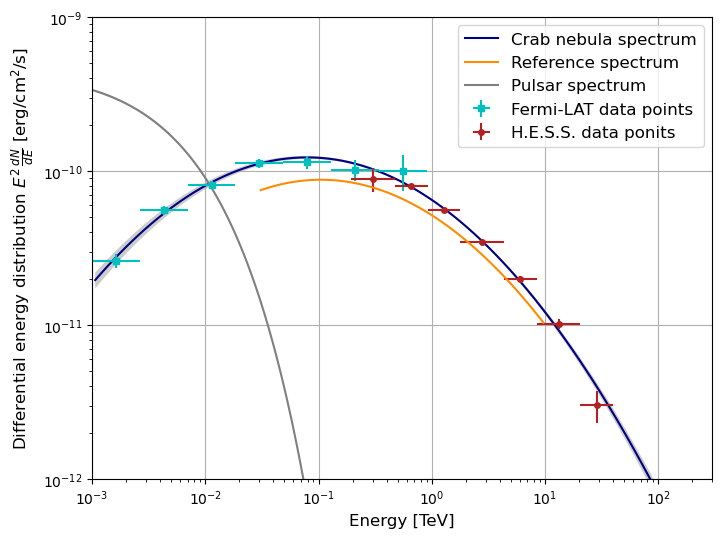

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

energy_bounds = [0.001, 300] * u.TeV
sed_type = "e2dnde"
plot_kwargs = {
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1")
}

crab_spec.plot(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    label="Crab nebula spectrum",
    color='navy'
)
crab_spec.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type
)

flux_points_fermi.plot(
    ax=ax,
    label="Fermi-LAT data points",
    sed_type=sed_type,
    color='c',
    marker='s'
)
flux_points_hess.plot(
    ax=ax,
    sed_type=sed_type,
    label="H.E.S.S. data ponits",
    color='firebrick'
)
ref_spectral_model = LogParabolaSpectralModel.from_log10(
    alpha=2.47,
    amplitude=3.23e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    beta=0.24,
)
ref_spectral_model.plot(
    ax=ax,
    energy_bounds=[0.03, 10] * u.TeV,
    sed_type=sed_type,
    label="Reference spectrum",
    color='darkorange'
)
pulsar_spec.plot(
    ax=ax,
    energy_bounds=[0.001, 0.1] * u.TeV,
    sed_type=sed_type,
    label="Pulsar spectrum",
    color='grey'
)
pulsar_spec.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type
)

ax.set_xlim(energy_bounds)
ax.set_ylim(10**-12, 10**-9)
ax.set_ylabel(
    'Differential energy distribution ' r'$E^2\, \frac{dN}{dE}$ [erg/cm$^2$/s]',
    fontsize=12
)
ax.set_xlabel('Energy [TeV]', fontsize=12)
ax.legend(fontsize=12)
ax.grid()
plt.show()


In [35]:
print(ref_spectral_model,pulsar_spec,crab_spec)
print(datasets[0].models["RGB J0512+212"].spectral_model)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 3.2300e-11 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.4700e+00                ... nan  False   False     
spectral      beta 1.0423e-01                ... nan  False   False      SuperExpCutoffPowerLaw4FGLDR3SpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 7.3083e-11 cm-2 MeV-1 s-1 ... nan  False    True     
spectral reference 1.5924e+03            MeV ... nan   True   False     
spectral expfactor 2.3667e-01                ... nan   True   False     
spectral   index_1 2.3200e+00                ... nan   True   False     
spectral   index_2 6.1035e-01                ... nan  

In [36]:
print(flux_points_hess.to_table(),'\n',flux_points_fermi.to_table())

       e_ref               e_min               e_max        ... counts success
        TeV                 TeV                 TeV         ...               
------------------- ------------------- ------------------- ... ------ -------
0.30329340116768627  0.1945887717576389 0.47272453780854895 ...   37.0    True
 0.6594274693415539 0.47272453780854895  0.9198688719186309 ... 3688.0    True
 1.2831718132242107  0.9198688719186309  1.7899615396473119 ... 3403.0    True
 2.7899015879248426  1.7899615396473119    4.34844587322206 ... 2060.0    True
  6.065868023353727    4.34844587322206   8.461587415248545 ...  479.0    True
 13.188549386831081   8.461587415248545    20.5561706560439 ...  196.0    True
  28.67484657747546    20.5561706560439                40.0 ...   22.0    True 
       e_ref              e_min              e_max        ...  counts success
       GeV                GeV                GeV         ...                
------------------ ------------------ ----------------

In [37]:
display(flux_points_hess.to_table(sed_type='dnde', formatted=True))
display(flux_points_fermi.to_table(sed_type='dnde', formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
0.303,0.195,0.473,6.045e-10,1.099e-10,8.488e-10,88.444,9.404,36.99982638851378,33.583157,0.000,False,37.0,True
0.659,0.473,0.920,1.154e-10,2.012e-12,1.195e-10,11232.001,105.981,3686.3140127266092,3491.5596,16.644,False,3688.0,True
1.283,0.920,1.790,2.133e-11,3.814e-13,2.210e-11,11396.646,106.755,3403.0095506157554,3268.1309,4.154,False,3403.0,True
2.790,1.790,4.348,2.771e-12,6.362e-14,2.900e-12,6945.025,83.337,2059.898730404097,1979.9806,2.934,False,2060.0,True
6.066,4.348,8.462,3.387e-13,1.598e-14,3.717e-13,1733.107,41.631,478.88641907980883,464.3566,0.536,False,479.0,True
13.189,8.462,20.556,3.670e-14,2.746e-15,4.245e-14,636.720,25.233,195.94162499188403,187.42921,2.757,False,196.0,True
28.675,20.556,40.000,2.291e-15,5.276e-16,3.500e-15,59.405,7.707,22.00542281209427,20.422564,0.039,False,22.0,True


e_ref,e_min,e_max,dnde,dnde_err,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
GeV,GeV,GeV,1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
1.626,1.000,2.643,6.179e-06,6.382e-07,99.470,9.973,33426.87809241544,1191.0757,-85863.643,False,35199.0,True
4.296,2.643,6.983,1.894e-06,1.277e-07,262.693,16.208,10110.291189656276,992.4554,-15946.617,False,9603.0,True
11.352,6.983,18.455,3.955e-07,2.434e-08,419.176,20.474,2931.368008196934,538.22565,-517.394,False,2128.0,True
30.000,18.455,48.768,7.801e-08,4.952e-09,762.388,27.611,882.752088544936,294.31528,468.204,False,578.0,True
79.279,48.768,128.876,1.132e-08,1.041e-09,850.628,29.166,269.53327688039855,120.17576,319.920,False,183.0,True
209.503,128.876,340.571,1.454e-09,2.329e-10,496.174,22.275,76.10053035483608,38.97456,108.218,False,48.0,True
553.637,340.571,900.000,2.045e-10,5.313e-11,184.720,13.591,29.475372183241568,14.875993,81.917,False,17.0,True


In [38]:
results_joint.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str17,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
source-crab,spectral,amplitude,4.0628e-11,cm-2 s-1 TeV-1,4.602e-13,nan,nan,False,True,
source-crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
source-crab,spectral,alpha,2.5007e+00,,1.072e-02,nan,nan,False,False,
source-crab,spectral,beta,9.8749e-02,,3.391e-03,nan,nan,False,False,
source-crab,spatial,lon_0,1.8455e+02,deg,2.311e-03,nan,nan,False,False,
source-crab,spatial,lat_0,-5.7778e+00,deg,2.382e-03,-9.000e+01,9.000e+01,False,False,
diffuse-iem,spectral,norm,1.0000e+00,,1.414e+00,nan,nan,False,True,
diffuse-iem,spectral,reference,1.0000e+01,TeV,0.000e+00,nan,nan,True,False,
diffuse-iem,spectral,alpha,2.0000e+00,,1.414e+00,nan,nan,False,False,


In [39]:
results_joint.models.to_parameters_table()['error'].pprint(30)
results_joint.models.to_parameters_table().pprint(30)

  error  
---------
4.602e-13
0.000e+00
1.072e-02
3.391e-03
2.311e-03
2.382e-03
1.414e+00
0.000e+00
1.414e+00
1.414e+00
8.758e-13
0.000e+00
1.322e-02
5.714e-03
2.808e-03
3.503e-03
1.066e-12
0.000e+00
0.000e+00
0.000e+00
0.000e+00
1.402e-03
1.442e-03
0.000e+00
1.110e-01
0.000e+00
0.000e+00
0.000e+00
      model         type      name      value    ... frozen is_norm link
----------------- -------- --------- ----------- ... ------ ------- ----
      source-crab spectral amplitude  4.0628e-11 ...  False    True     
      source-crab spectral reference  1.0000e+00 ...   True   False     
      source-crab spectral     alpha  2.5007e+00 ...  False   False     
      source-crab spectral      beta  9.8749e-02 ...  False   False     
      source-crab  spatial     lon_0  1.8455e+02 ...  False   False     
      source-crab  spatial     lat_0 -5.7778e+00 ...  False   False     
      diffuse-iem spectral      norm  1.0000e+00 ...  False    True     
      diffuse-iem spectral reference  1.000